In [59]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp
from scipy import constants 


In [60]:
import ducktrack as dtk

data = np.load('emittance_betacool.npz')
emittance_betacool = data['emittance']
time_betacool = data['time']

gamma0 = 1.004469679
beta0 = np.sqrt(1 - 1 / gamma0**2)
mass0 = 193729.0248722061 * 1e6  # eV/c^2
clight = 299792458.0
p0c = mass0 * beta0 * gamma0  # eV/c
q0 = 54
particle_ref = xp.Particles(p0c=p0c,q0=q0,mass0=mass0,beta0=beta0,gamma0=gamma0)

circumference = 78.54370266  # m
T_per_turn = circumference/(clight*beta0)

qx = 1.82
qy = 2.72
beta_x = 5
beta_y = 5
qs=0.005247746218929317
bets0=-2078.673348423543

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        length=circumference,
        betx=beta_x,
        bety=beta_y,
        )

arc_matching = xt.LineSegmentMap(
        qx=qx, qy=qy,
        length=circumference,
        betx=beta_x,
        bety=beta_y,
        qs=qs,
        bets=bets0)

line_matching=xt.Line([arc_matching])
line_matching.build_tracker()

num_particles=int(1e2)
sigma_dp = 5e-3    
gemitt_x = 14e-6
gemitt_y = 14e-6

nemitt_x = gemitt_x*beta0*gamma0
nemitt_y = gemitt_y*beta0*gamma0

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=4.2,
        particle_ref=particle_ref,
        line=line_matching,        
        )

particles.delta = np.random.normal(loc=0.0, scale=sigma_dp, size=num_particles)
particles.zeta = np.random.uniform(-circumference/2, circumference/2, num_particles)

max_time_s = 1
int_time_s = 1*1e-3
num_turns = int((max_time_s / T_per_turn).item())
save_interval = int((int_time_s / T_per_turn).item())

monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                        n_repetitions=int(num_turns/save_interval),
                        repetition_period=save_interval,
                        num_particles=len(particles.x))

current = 0.6  # amperes
cooler_length = 2.5  # m cooler length
radius_e_beam = 25 * 1e-3
temp_perp = 100e-3 # <E> [eV] = kb*T
temp_long =  1e-3 # <E> [eV]
magnetic_field = 0.075  # T for LEIR

electron_cooler = xt.ElectronCooler(current=current,
                                length=cooler_length,
                                radius_e_beam=radius_e_beam,
                                temp_perp=temp_perp, temp_long=temp_long,
                                magnetic_field=magnetic_field)

line = xt.Line(elements=[monitor, electron_cooler, arc],element_names=['monitor','electron_cooler','arc'])                                    
line.particle_ref = particle_ref
#context = xo.ContextCpu(omp_num_threads=4)
line.build_tracker()

line.track(particles, num_turns=num_turns,
        turn_by_turn_monitor=False,with_progress=True)

x = monitor.x[:,:,0]
px = monitor.px[:,:,0]
#y = monitor.y[:,:,0]
#py = monitor.py[:,:,0]
#delta = monitor.delta[:,:,0]
#zeta = monitor.zeta[:,:,0]
time = monitor.at_turn[:, 0, 0] * T_per_turn

action_x = (x**2/beta_x + beta_x*px**2)
geo_emittance_x=np.mean(action_x,axis=1)/2

valid_indices = ~np.isnan(time_betacool)
time_betacool = time_betacool[valid_indices]
matched_indices = [np.abs(time - tb).argmin() for tb in time_betacool]
emittance_xsuite = geo_emittance_x[matched_indices]
emittance_betacool_matched=emittance_betacool[:len(emittance_xsuite)]
emittance_diff = emittance_xsuite - emittance_betacool[:len(emittance_xsuite)]
mse_emittance = np.mean(emittance_diff**2)



Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/359700 [00:00<?, ?it/s]

In [68]:
import xobjects as xo

xo.assert_allclose(emittance_xsuite, emittance_betacool_matched, rtol=0, atol=1e-5)

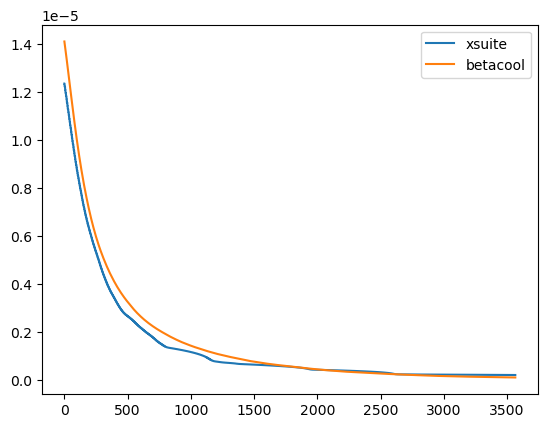

In [62]:
plt.figure()
plt.plot(emittance_xsuite,label='xsuite')
plt.plot(emittance_betacool,label='betacool')
plt.legend()
plt.show()
